# Confidence Interval:
In this notebook you will find:
- Get confidence intervals for predicted survival curves using XGBSE estimators;
- How to use XGBSEBootstrapEstimator, a meta estimator for bagging;
- A nice function to help us plot survival curves.

In [1]:
import matplotlib.pyplot as plt

plt.style.use("bmh")

from IPython.display import set_matplotlib_formats

set_matplotlib_formats("retina")

# to easily plot confidence intervals
def plot_ci(
    mean, upper_ci, lower_ci, i=42, title="Probability of survival $P(T \geq t)$"
):

    # plotting mean and confidence intervals
    plt.figure(figsize=(12, 4), dpi=120)
    plt.plot(mean.columns, mean.iloc[i])
    plt.fill_between(mean.columns, lower_ci.iloc[i], upper_ci.iloc[i], alpha=0.2)

    plt.title(title)
    plt.xlabel("Time [days]")
    plt.ylabel("Probability")
    plt.tight_layout()

/tmp/ipykernel_35180/2871653077.py:5: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


## Metrabic

We will be using the Molecular Taxonomy of Breast Cancer International Consortium (METABRIC) dataset from [pycox](https://github.com/havakv/pycox#datasets) as base for this example.

In [2]:
from xgbse.converters import convert_to_structured
from pycox.datasets import metabric
import numpy as np

# getting data
df = metabric.read_df()

df.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,duration,event
0,5.603834,7.811392,10.797988,5.967607,1.0,1.0,0.0,1.0,56.840000,99.333336,0
1,5.284882,9.581043,10.204620,5.664970,1.0,0.0,0.0,1.0,85.940002,95.733330,1
2,5.920251,6.776564,12.431715,5.873857,0.0,1.0,0.0,1.0,48.439999,140.233337,0
3,6.654017,5.341846,8.646379,5.655888,0.0,0.0,0.0,0.0,66.910004,239.300003,0
4,5.456747,5.339741,10.555724,6.008429,1.0,0.0,0.0,1.0,67.849998,56.933334,1


## Split and Time Bins

Split the data in train and test, using sklearn API. We also setup the TIME_BINS array, which will be used to fit the survival curve.

In [3]:
from xgbse.converters import convert_to_structured
from sklearn.model_selection import train_test_split

# splitting to X, T, E format
X = df.drop(["duration", "event"], axis=1)
T = df["duration"]
E = df["event"]
y = convert_to_structured(T, E)

# splitting between train, and validation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1 / 3, random_state=0
)
TIME_BINS = np.arange(15, 315, 15)
TIME_BINS

array([ 15,  30,  45,  60,  75,  90, 105, 120, 135, 150, 165, 180, 195,
       210, 225, 240, 255, 270, 285, 300])

## Calculating confidence intervals

We will be using the XGBSEKaplanTree estimator to fit the model and predict a survival curve for each point in our test data, and via <i>return_ci</i> parameter we will get upper and lower bounds for the confidence interval.

In [4]:
from xgbse import XGBSEKaplanTree, XGBSEBootstrapEstimator
from xgbse.metrics import concordance_index, approx_brier_score

# xgboost parameters to fit our model
PARAMS_TREE = {
    "objective": "survival:cox",
    "eval_metric": "cox-nloglik",
    "tree_method": "hist",
    "max_depth": 10,
    "booster": "dart",
    "subsample": 1.0,
    "min_child_weight": 50,
    "colsample_bynode": 1.0,
}

### Numerical Form

The KaplanTree and KaplanNeighbors models support estimation of confidence intervals via the Exponential Greenwood formula.

C-index: 0.6358942056527093
Avg. Brier Score: 0.182841148106733
CPU times: user 1.03 s, sys: 94.4 ms, total: 1.13 s
Wall time: 498 ms


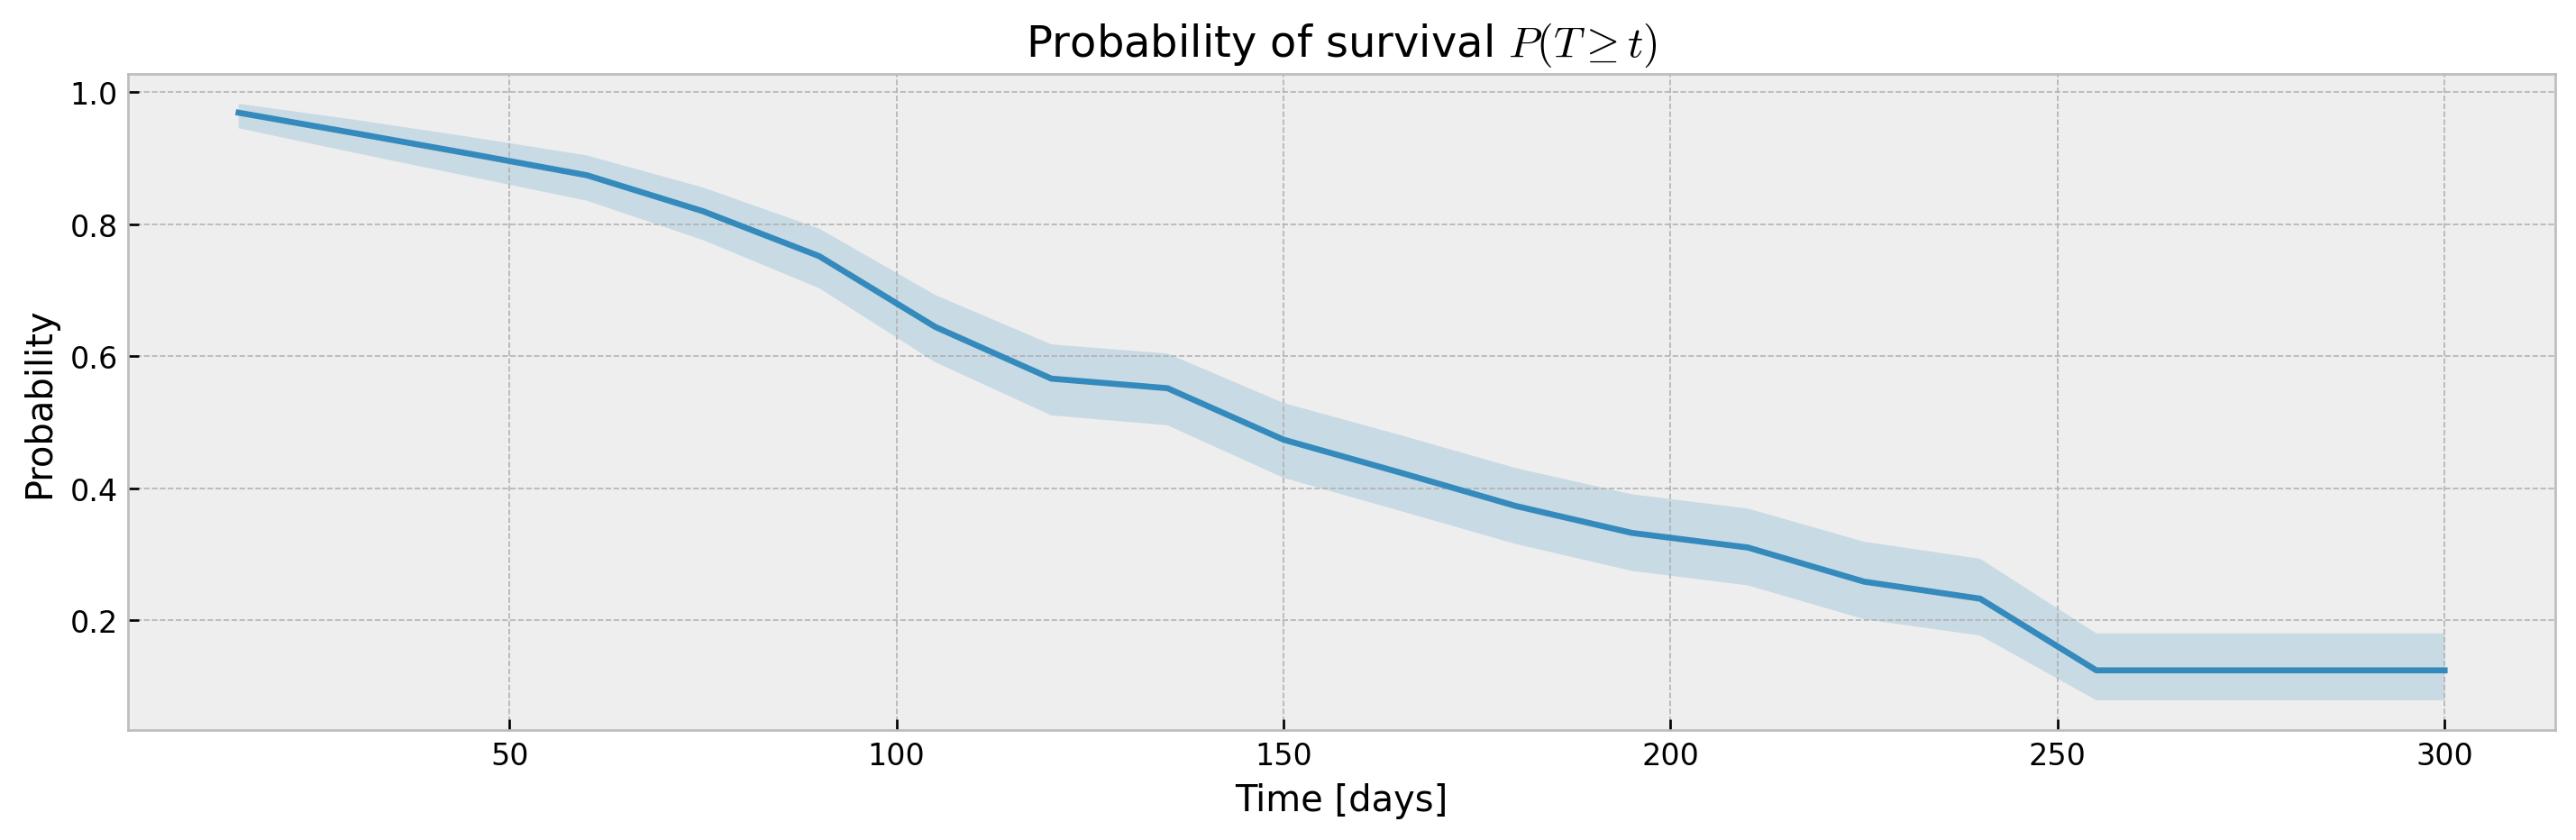

In [5]:
%%time

# fitting xgbse model
xgbse_model = XGBSEKaplanTree(PARAMS_TREE)
xgbse_model.fit(X_train, y_train, time_bins=TIME_BINS)

# predicting
mean, upper_ci, lower_ci = xgbse_model.predict(X_test, return_ci=True)

# print metrics
print(f"C-index: {concordance_index(y_test, mean)}")
print(f"Avg. Brier Score: {approx_brier_score(y_test, mean)}")

# plotting CIs
plot_ci(mean, upper_ci, lower_ci)

### Non-parametric Form

We can also use the XGBSEBootstrapEstimator to wrap any XGBSE model and get confidence intervals via bagging, which also slighty increase our performance at the cost of computation time.

C-index: 0.6580651819585904
Avg. Brier Score: 0.17040560738276275
CPU times: user 28.8 s, sys: 53.6 ms, total: 28.9 s
Wall time: 2.39 s


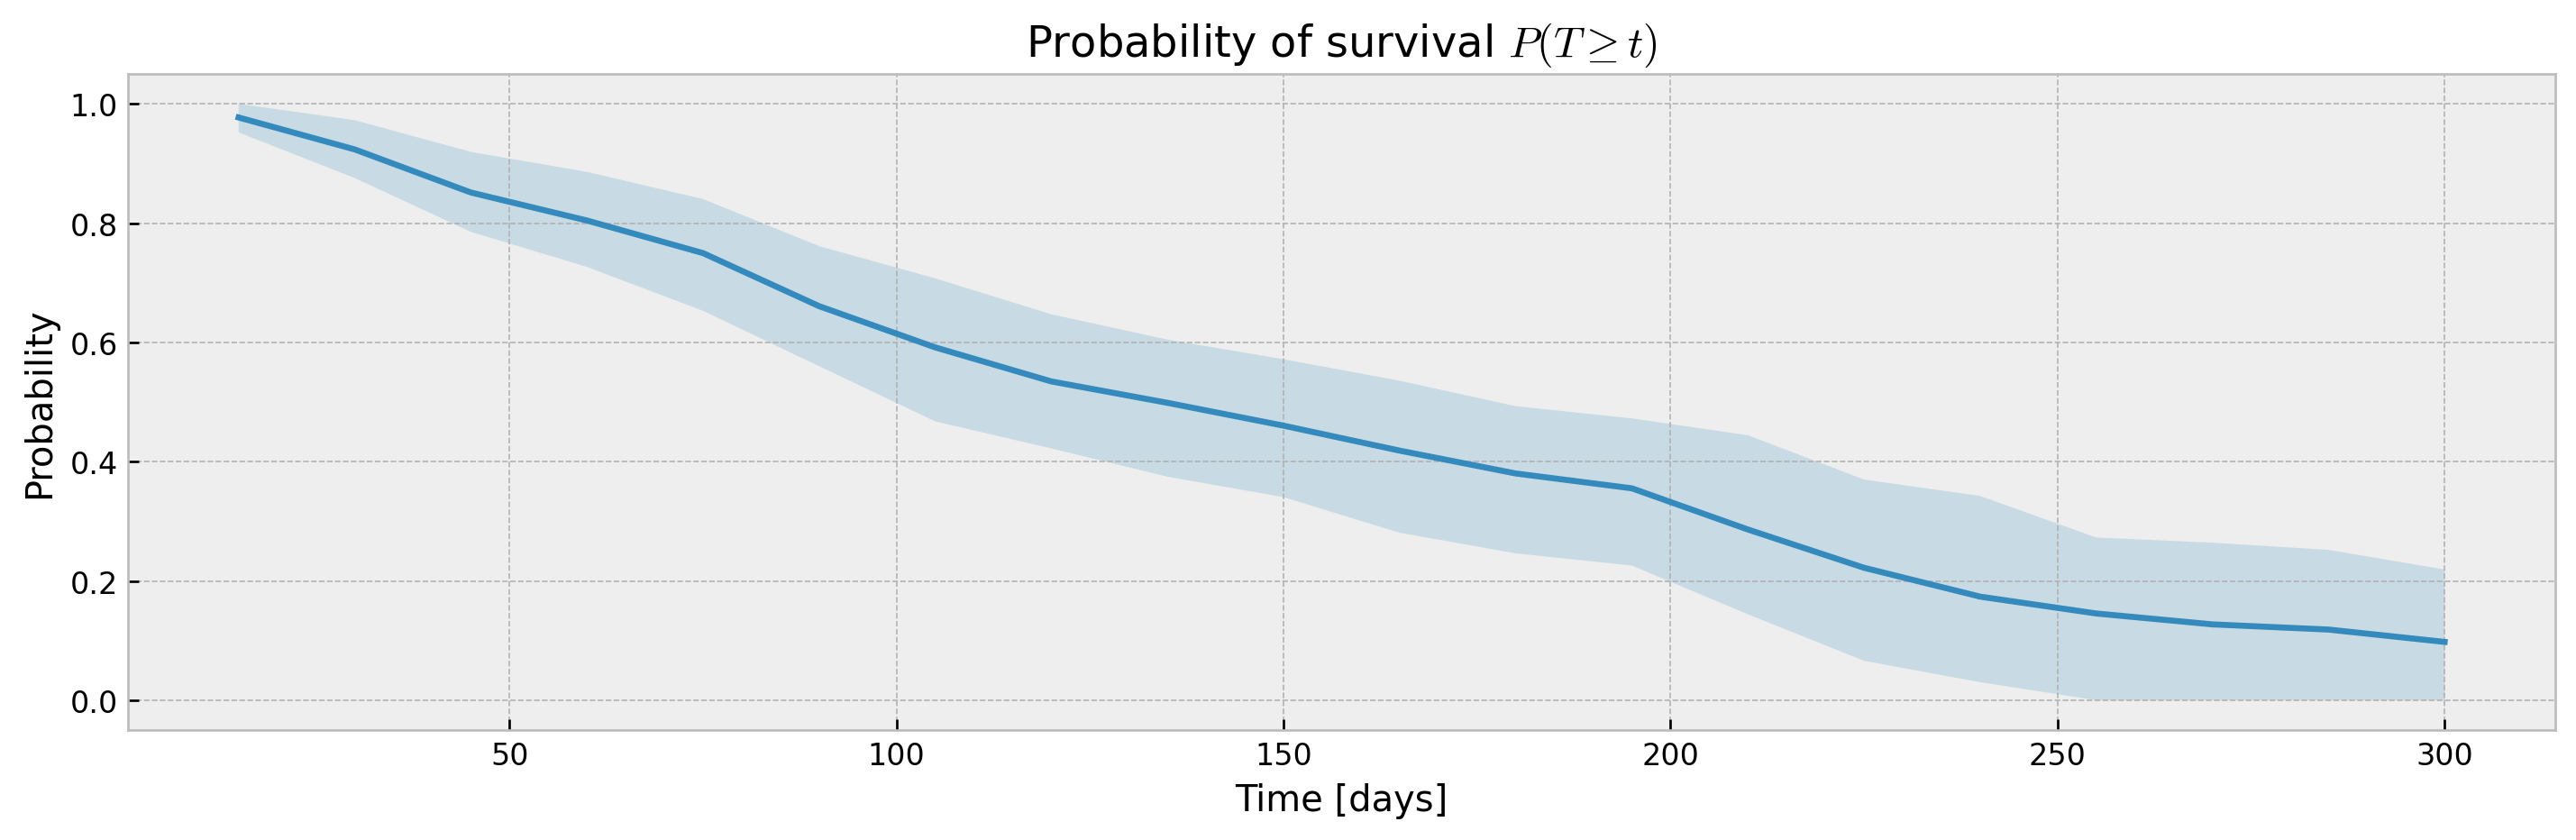

In [6]:
%%time

# base model as XGBSEKaplanTree
base_model = XGBSEKaplanTree(PARAMS_TREE)

# bootstrap meta estimator
bootstrap_estimator = XGBSEBootstrapEstimator(base_model, n_estimators=100)

# fitting the meta estimator
bootstrap_estimator.fit(X_train, y_train, time_bins=TIME_BINS)

# predicting
mean, upper_ci, lower_ci = bootstrap_estimator.predict(X_test, return_ci=True)

# print metrics
print(f"C-index: {concordance_index(y_test, mean)}")
print(f"Avg. Brier Score: {approx_brier_score(y_test, mean)}")

# plotting CIs
plot_ci(mean, upper_ci, lower_ci)